# Importing required libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown


# Importing the dataset

##### The dataset has 2 files: `train.csv` and `valid.csv` with a proportion of 70:30 images and a total of 10k images.

**Real:** NVIDIA Research's Flickr-Faces-HQ Dataset. Represented as 1 in dataset.  
**Fake:** Bojan Tunguz's 1 Million Fake Face dataset generated by StyleGAN. Represented as 0 in dataset


In [2]:
train_file_path = os.path.join(os.getcwd(), '..', 'Data', 'train.csv')
valid_file_path = os.path.join(os.getcwd(), '..', 'Data', 'valid.csv')

train_df = pd.read_csv(train_file_path)
valid_df = pd.read_csv(valid_file_path)

In [3]:
pd.concat([train_df.sample(2).assign(Source='train_df'), 
           valid_df.sample(2).assign(Source='valid_df')])

,Unnamed: 0,original_path,id,label,label_str,path,Source
6392,17697,/kaggle/input/1-million-fake-faces/1m_faces_00...,S02JBUNPMM,0,fake,train/fake/S02JBUNPMM.jpg,train_df
4902,40154,/kaggle/input/1-million-fake-faces/1m_faces_04...,HWLDNOI914,0,fake,train/fake/HWLDNOI914.jpg,train_df
2500,31158,/kaggle/input/1-million-fake-faces/1m_faces_00...,UHCL6Q2IK0,0,fake,valid/fake/UHCL6Q2IK0.jpg,valid_df
1358,1130,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31561,1,real,valid/real/31561.jpg,valid_df


#### Updating images path to absolute path from relative for modelling

**From:** train/real/04727.jpg  \
**To:** D:\Git\DeepGuard\Notebooks\\..\Data\train\real\04727.jpg



In [4]:
base_images_path = os.path.join(os.getcwd(), '..', 'Data')

## Replacing '/' in the dataframe with '\'
train_df['path'] = train_df['path'].str.replace('/', '\\')
valid_df['path'] = valid_df['path'].str.replace('/', '\\')

## Adding getcwd() path to dataframe
train_df['path'] = train_df['path'].apply(lambda path: os.path.join(base_images_path, path))
valid_df['path'] = valid_df['path'].apply(lambda path: os.path.join(base_images_path, path))

#### Removing unwanted columns

In [5]:
drop_columns = ['Unnamed: 0', 'original_path', 'id']
train_df.drop(columns=drop_columns, inplace=True)
valid_df.drop(columns=drop_columns, inplace=True)

#### Sampling 3 images from each training and validation

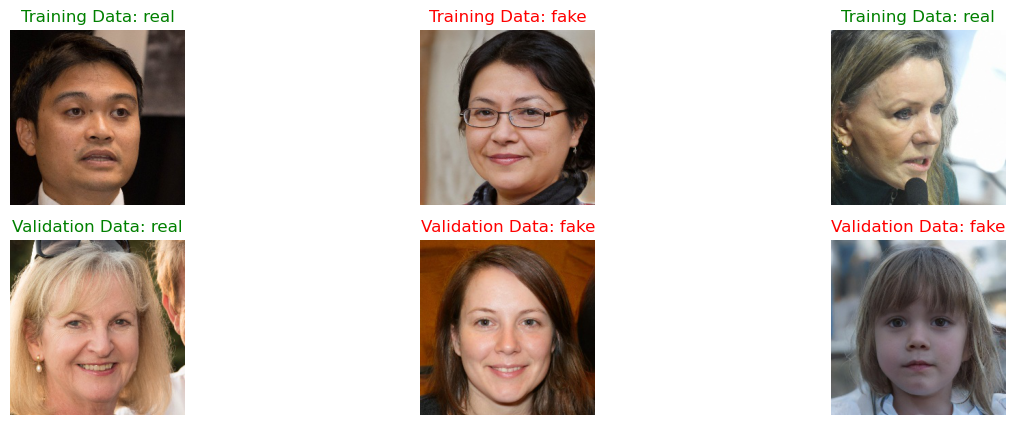

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
sample_images = pd.concat([train_df.sample(3).assign(Source='Training Data'), valid_df.sample(3).assign(Source='Validation Data')])

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    path = row['path']
    label = row['label_str']
    title = row['Source'] + ': ' + label
    
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=12, color='green' if label=='real' else 'red')

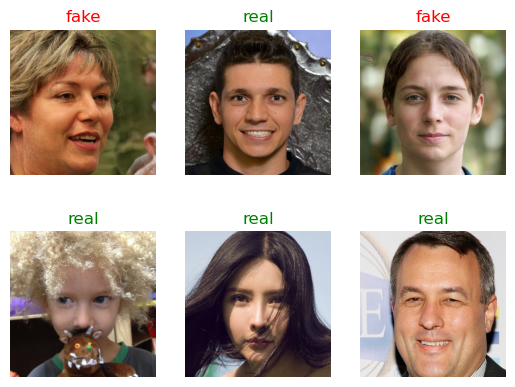

In [132]:
fig, axes = plt.subplots(2, 3)
sample_images = pd.concat([train_df.sample(3).assign(Source='Training Data'), valid_df.sample(3).assign(Source='Validation Data')])

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    path = row['path']
    label = row['label_str']
    title = label
    
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=12, color='green' if label=='real' else 'red')

# Train Test Split with (Train, Validation, Test = 70,10,20)
Using train_df for training and valid_df for validation and test.

**Train_df (70%)**  
 - Training(100%) - 7k images
 
**Valid_df (30%)**: Perform 67-33 split for test and validation
 - Test(67%) - 2k images
 - Validation(33%) - 1k images  

In [7]:
# Initial Dataset
display(Markdown('**Initial Counts before Split**'))
display(pd.concat([train_df['label_str'].value_counts(), valid_df['label_str'].value_counts()], axis=1, keys=['Train', 'Validation']))

#Splitting valid_df into validation and test dataset in 10-20 proportion of total data
validation_df, test_df = train_test_split(valid_df, test_size=0.67, random_state=1000)
display(Markdown('**After Test-Validation Split**'))
display(pd.concat([train_df['label_str'].value_counts(), validation_df['label_str'].value_counts(), test_df['label_str'].value_counts()], axis=1, 
                  keys=['Train', 'Validation', 'Test']))

**Initial Counts before Split**

,Train,Validation
label_str,,
real,3500,1500
fake,3500,1500


**After Test-Validation Split**

,Train,Validation,Test
label_str,,,
real,3500,493,1007
fake,3500,496,1004


In [11]:
# # Train, Val and Test Dataset 
# X_train = train_df['path'].values
# y_train = train_df['label'].values

# X_val = validation_df['path'].values
# y_val = validation_df['label'].values

# X_test = test_df['path'].values
# y_test = test_df['label'].values

## Preprocess - Resize (224*224) & Normalize Pixel Values [0,1]

Occupies too much memory so using ImageDataGenerator to perform these steps during training

In [11]:
# def preprocess_image(image_path, image_size= (224,224)):
#     # Load + Resize
#     img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
#     # image to array
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     # Normalization
#     img_array = img_array / 255.0
#     return img_array

# # preprocess_image(train_df['path'][0], image_size).shape
# image_size = (224,224)

# X_train_processed = [preprocess_image(image_path, image_size) for image_path in X_train]
# X_val_processed = [preprocess_image(image_path, image_size) for image_path in X_val]
# X_test_processed = [preprocess_image(image_path, image_size) for image_path in X_test]

## Augmentation

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,    # Normalizing pixel values [0,1]
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,    # Normalizing pixel values [0,1]
)

In [9]:
image_size = (224, 224)
batch_size=32

train_augmented_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

valid_augmented_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_augmented_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label_str',
    target_size=image_size, 
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)

Found 7000 validated image filenames belonging to 2 classes.
Found 989 validated image filenames belonging to 2 classes.
Found 2011 validated image filenames belonging to 2 classes.


## Define Model Architecture

#### Model 1

In [8]:
model1 = Sequential([                                                  # 224x224x3
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 222x222x32
    MaxPooling2D(pool_size=(2, 2)),                                    # 111x111x32 
    
    Conv2D(64, (3, 3), activation='relu'),                             # 109x109x64
    MaxPooling2D(pool_size=(2, 2)),                                    # 54x54x64

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),                                                         
    Dense(256, activation='relu'),                                     
    Dropout(0.5),                                                      
    Dense(1, activation='sigmoid')                                     
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

#### Model 2 - Using Batch Normalization

In [35]:
model2 = Sequential([                                                  # 224x224x3
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 222x222x32
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),                                    # 111x111x32 
    
    Conv2D(64, (3, 3), activation='relu'),                             # 109x109x64
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),                                    # 54x54x64

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),                                                         
    Dense(256, activation='relu'),                                     
    Dropout(0.5),                                                      
    Dense(1, activation='sigmoid')                                     
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

In [16]:
model3 = Sequential([
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Conv2D(512, (3, 3), activation='relu', padding='same'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    
    # Conv2D(512, (3, 3), activation='relu', padding='same'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# model3.summary()

## Training models

In [11]:
def train_gen (model, train_generator, valid_generator, epochs, batch_size):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        batch_size=batch_size
    )

    return history

#### Training Model 1

In [28]:
model1.load_weights('model1_50.h5')

In [29]:
batch_size = 32
epochs=25

# history1 = train_gen(model1, train_augmented_generator, valid_augmented_generator, 10, 32)
history1 = model1.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/25
219/219 [==============================] - 67s 305ms/step - loss: 0.5483 - accuracy: 0.7254 - val_loss: 0.5322 - val_accuracy: 0.7401
Epoch 2/25
219/219 [==============================] - 67s 307ms/step - loss: 0.5401 - accuracy: 0.7311 - val_loss: 0.5181 - val_accuracy: 0.7422
Epoch 3/25
219/219 [==============================] - 67s 303ms/step - loss: 0.5437 - accuracy: 0.7303 - val_loss: 0.5109 - val_accuracy: 0.7553
Epoch 4/25
219/219 [==============================] - 67s 307ms/step - loss: 0.5430 - accuracy: 0.7257 - val_loss: 0.5360 - val_accuracy: 0.7250
Epoch 5/25
219/219 [==============================] - 70s 321ms/step - loss: 0.5370 - accuracy: 0.7359 - val_loss: 0.5368 - val_accuracy: 0.7442
Epoch 6/25
219/219 [==============================] - 85s 390ms/step - loss: 0.5363 - accuracy: 0.7280 - val_loss: 0.5438 - val_accuracy: 0.7118
Epoch 7/25
219/219 [==============================] - 81s 368ms/step - loss: 0.5314 - accuracy: 0.7369 - val_loss: 0.5056 - val_ac

In [30]:
model1.save_weights('model1_75.h5')

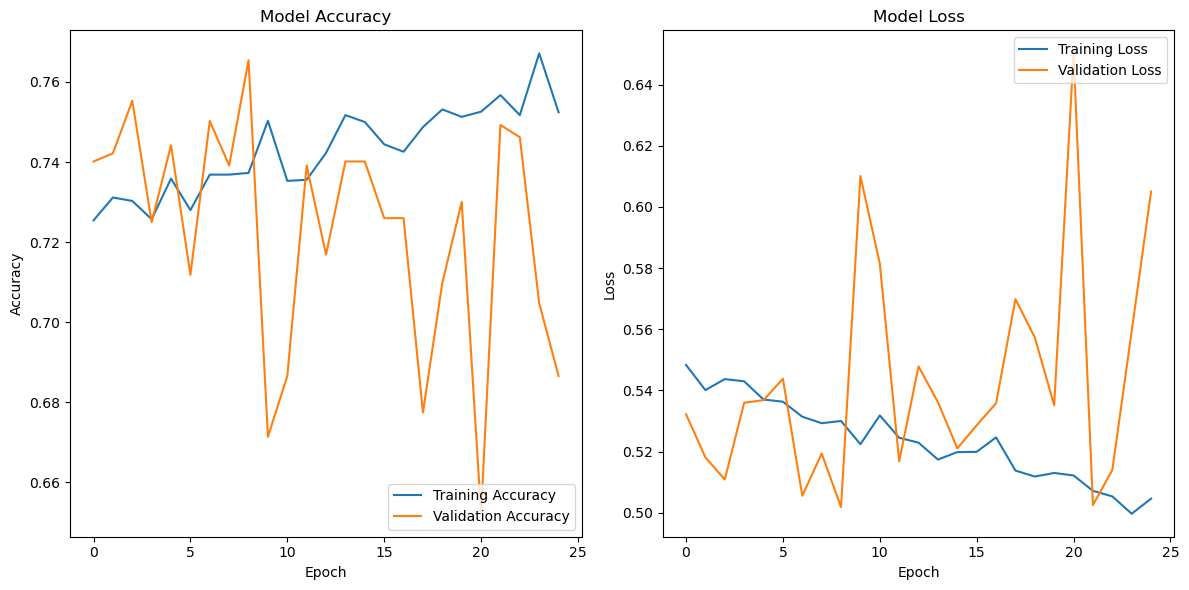

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history1.history['accuracy'], label='Training Accuracy')
axs[0].plot(history1.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history1.history['loss'], label='Training Loss')
axs[1].plot(history1.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


#### Training Model 2

In [53]:
model2.load_weights('model2_50.h5')

In [43]:
batch_size = 32
epochs=25

# history2 = train_gen(model2, train_augmented_generator, valid_augmented_generator, 10, 32)
history2 = model2.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/25
219/219 [==============================] - 70s 316ms/step - loss: 0.6208 - accuracy: 0.6660 - val_loss: 0.6084 - val_accuracy: 0.6886
Epoch 2/25
219/219 [==============================] - 75s 340ms/step - loss: 0.6084 - accuracy: 0.6801 - val_loss: 0.5560 - val_accuracy: 0.7432
Epoch 3/25
219/219 [==============================] - 72s 330ms/step - loss: 0.6247 - accuracy: 0.6734 - val_loss: 0.5952 - val_accuracy: 0.6653
Epoch 4/25
219/219 [==============================] - 71s 326ms/step - loss: 0.5967 - accuracy: 0.6859 - val_loss: 0.5934 - val_accuracy: 0.6775
Epoch 5/25
219/219 [==============================] - 70s 321ms/step - loss: 0.5941 - accuracy: 0.6874 - val_loss: 0.5977 - val_accuracy: 0.6785
Epoch 6/25
219/219 [==============================] - 70s 318ms/step - loss: 0.5899 - accuracy: 0.6919 - val_loss: 0.5688 - val_accuracy: 0.7088
Epoch 7/25
219/219 [==============================] - 70s 319ms/step - loss: 0.5864 - accuracy: 0.6900 - val_loss: 0.5638 - val_ac

In [44]:
model2.save_weights('model2_50.h5')

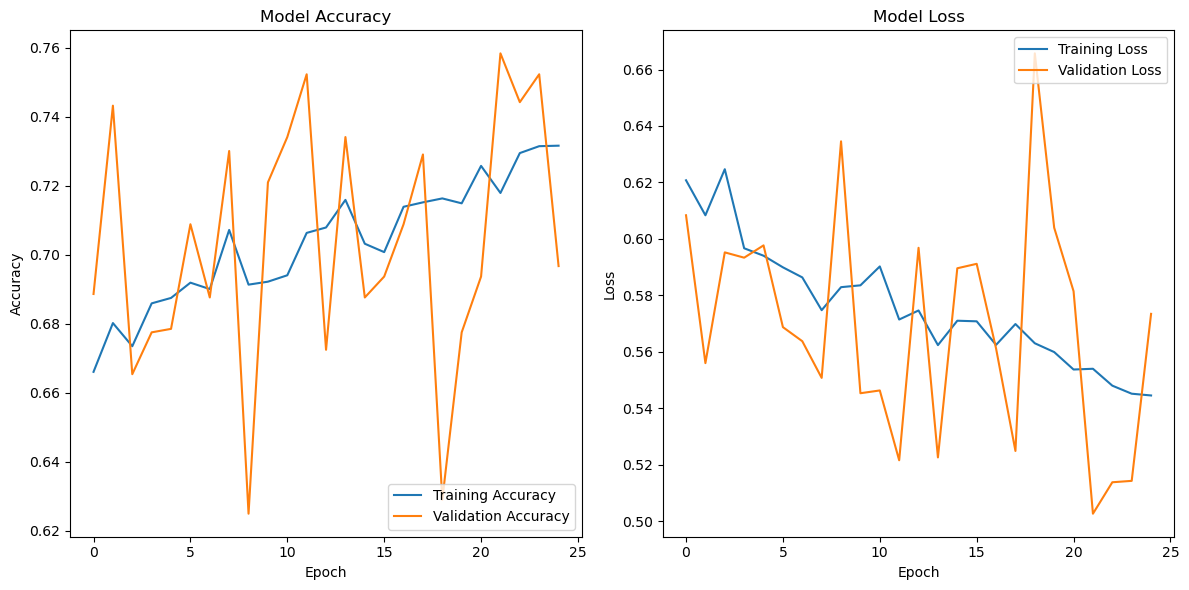

In [45]:
history = history2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


#### Training Model 3

In [53]:
model3.load_weights('model3_25.h5')

In [17]:
batch_size = 2
epochs=25

# history2 = train_gen(model2, train_augmented_generator, valid_augmented_generator, 10, 32)
history3 = model3.fit(
    train_augmented_generator,
    steps_per_epoch=len(train_augmented_generator),
    epochs=epochs,
    validation_data=valid_augmented_generator,
    validation_steps=len(valid_augmented_generator),
    batch_size=batch_size
)

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_5/batch_normalization_15/FusedBatchNormGradV3' defined at (most recent call last):
    File "C:\ProgramData\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\ProgramData\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\anaconda3\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\ProgramData\anaconda3\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\ProgramData\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\ProgramData\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\patel\AppData\Local\Temp\ipykernel_5708\284566150.py", line 5, in <module>
      history3 = model3.fit(
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_5/batch_normalization_15/FusedBatchNormGradV3'
OOM when allocating tensor with shape[32,64,222,222] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_5/batch_normalization_15/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5330]

In [44]:
model3.save_weights('model2_50.h5')

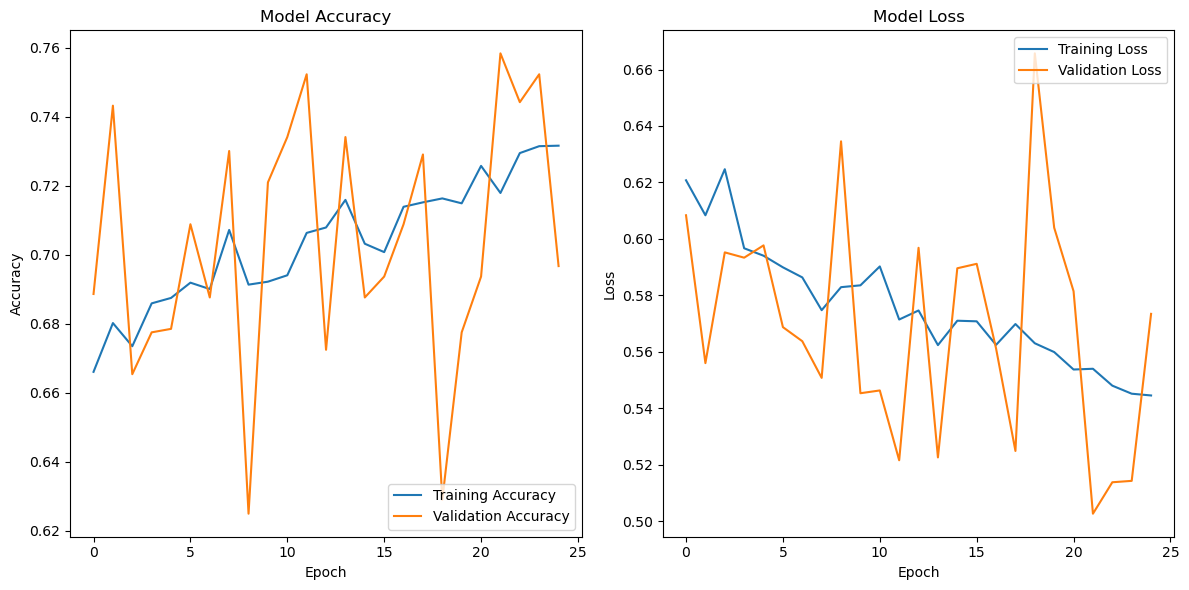

In [45]:
history = history3
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


## Test

In [15]:
def test_predictions_gen (model, test_generator):
    y_pred = model.predict(test_augmented_generator)    
    return y_pred

def test_evaluate_gen (model, test_generator):
    loss, accuracy = model.evaluate(test_augmented_generator, steps=len(test_augmented_generator))
    return loss, accuracy
    

In [32]:
# y_pred1 = test_predictions_gen(model1, test_augmented_generator)
loss, accuracy = test_evaluate_gen(model1, test_augmented_generator)
print("Test Accuracy:", accuracy)


63/63 [==============================] - 21s 337ms/step - loss: 0.6443 - accuracy: 0.6778
Test Accuracy: 0.6777722239494324


In [46]:
loss, accuracy = test_evaluate_gen(model2, test_augmented_generator)
print("Test Accuracy:", accuracy)

63/63 [==============================] - 4s 53ms/step - loss: 0.6259 - accuracy: 0.6842
Test Accuracy: 0.6842367053031921


Confusion Matrix:
[[682 322]
 [428 579]]


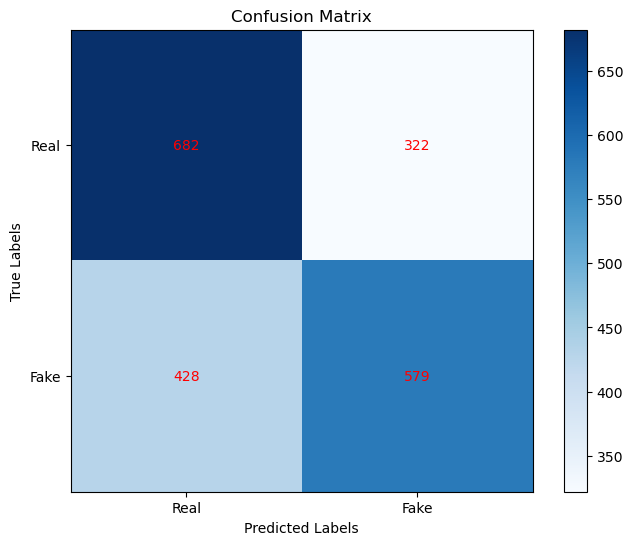

In [117]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate confusion matrix
y_pred1 = np.round(y_pred1).astype(int)
y_test = test_df['label'].values

conf_matrix = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.yticks([0, 1], ['Real', 'Fake'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')
plt.show()

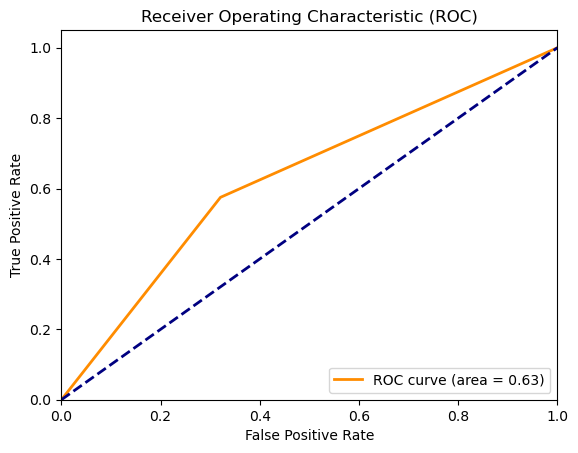

In [119]:
# Generate ROC curve and compute AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [19]:
%whos

Variable                    Type                  Data/Info
-----------------------------------------------------------
BatchNormalization          type                  <class 'keras.layers.norm<...>tion.BatchNormalization'>
Conv2D                      type                  <class 'keras.layers.conv<...>olutional.conv2d.Conv2D'>
Dense                       type                  <class 'keras.layers.core.dense.Dense'>
Dropout                     type                  <class 'keras.layers.regu<...>ization.dropout.Dropout'>
Flatten                     type                  <class 'keras.layers.reshaping.flatten.Flatten'>
Image                       module                <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
Markdown                    type                  <class 'IPython.core.display.Markdown'>
MaxPooling2D                type                  <class 'keras.layers.pool<...>_pooling2d.MaxPooling2D'>
Sequential                  type                  <class 'keras.engine.

In [50]:
import tensorflow as tf

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

# Check if cuDNN is enabled
if tf.test.is_built_with_cuda():
    print("cuDNN is enabled.")
else:
    print("cuDNN is not enabled.")

TensorFlow version: 2.10.0
GPU is available.
cuDNN is enabled.


In [ ]:
# %whos
import resource

# Define a function to get memory usage of a variable
def get_size(variable):
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

# Print memory usage of a specific variable
print("Memory usage of variable_name:", get_size(variable_name))
